# Sirius Workshop 2019

This tutorial is prepared by Ivan Fursov at Tinkoff.

Telegram: [@fursov](https://tele.click/fursov)

# Paraphrase identification

**Download** files from [here](https://yadi.sk/d/pTSMZfLAo7DjrQ)

Task: given a pair of sentences, classify them as paraphrases or not paraphrases

Dataset: [Quora Question Pairs](https://www.kaggle.com/quora/question-pairs-dataset)

Quora's first public dataset is related to the problem of identifying duplicate questions. At Quora, an important product principle is that there should be a single question page for each logically distinct question. For example, the queries “What is the most populous state in the USA?” and “Which state in the United States has the most people?” should not exist separately on Quora because the intent behind both is identical. 

In [1]:
import re
import os

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

pd.set_option('max_colwidth', 80)

In [2]:
def clean_string(string):
    """
    Remove non-letter symbols, lower the text
    """
    string = re.sub(r"[^A-Za-z ]", " ", string)  
    return string.strip().lower()

In [3]:
# load the data

data = pd.read_csv('data/questions.csv', nrows=1000)
data = data.dropna()

data['question1'] = data['question1'].apply(clean_string)
data['question2'] = data['question2'].apply(clean_string)

data = data[['question1', 'question2', 'is_duplicate']]
data.columns = ['text1', 'text2', 'labels']

data = data[data['text1'].apply(lambda x: len(x) > 0) & (data['text2'].apply(lambda x: len(x) > 0))]

### Dataset structure

There are three columns: **text1**, **text2** and **labels**. **text1**, **text2** are strings and **labels** can take 2 values: $0$, $1$. $1$ corresponds to "texts have similar meaning", and $0$ --- otherwise.

In [4]:
data.sample(5)

,text1,text2,labels
714,what is the fastest production car,what is the world s fastest street legal car,0
284,how can i make money online with free of cost,how do i to make money online,1
623,how should i respond to my boss who fired me via email,is it okay to fire someone via email,0
453,what are the differences between pocso and sexual offenses in the ipc,do we need the ipc section,0
295,what will be the effect of banning and notes on stock markets in india,what will be the effect of the ban of the rs and rs notes on the stoc...,1


### Train/Dev/Test

In [5]:
# train/dev/test -> 70/15/15
data_splits = ('train', 'dev', 'test')

train, intermediate = train_test_split(data, test_size=0.3, random_state=24)
dev, test = train_test_split(intermediate, test_size=0.5, random_state=24)

In [6]:
train.shape, dev.shape, test.shape

((700, 3), (150, 3), (150, 3))

# Baseline approaches


## Text representations
### Bag-of-Words

Bag of Words (BoW) is an algorithm that counts how many times a word appears in a document. Those word counts allow us to compare documents and gauge their similarities for applications like search, document classification and topic modeling.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict

import scipy
from scipy.sparse import csr_matrix

$$
{\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}
$$

In [8]:
def calculate_cosine_distance(textA, textB):
    textA = normalize(textA)
    textB = normalize(textB)
    if isinstance(textA, np.ndarray):
        dot_product = np.multiply(textA, textB).sum(axis=1).flatten()
    else:
        dot_product = np.array(textA.multiply(textB).sum(axis=1)).flatten()
    return 1 - dot_product

In [9]:
bow = CountVectorizer()
bow.fit(train['text1'].tolist() + train['text2'].tolist())

bow_data = {name: dict() for name in data_splits}

for d, name in zip((train, dev, test), data_splits):
    bow_data[name]['text1'] = bow.transform(d['text1'].tolist())
    bow_data[name]['text2'] = bow.transform(d['text2'].tolist())

In [10]:
bow_data['train']['text1'].shape, bow_data['train']['text2'].shape

((700, 3010), (700, 3010))

In [11]:
def calculate_score(textA, textB, labels):
    cos_dists = calculate_cosine_distance(textA, textB)

    best_f1 = 0
    best_thres = None

    for thres in np.linspace(0, 2, num=50):
        f1 = f1_score((cos_dists < thres).astype(np.int32), labels)
        if f1 > best_f1:
            best_f1 = f1
            best_thres = thres
            
    return best_f1, best_thres

In [12]:
best_f1, best_thres = calculate_score(
    bow_data['dev']['text1'], 
    bow_data['dev']['text2'],
    dev['labels'].values
)

print(f'(DEV) F1 score = {best_f1}')

(DEV) F1 score = 0.6190476190476191


In [13]:
test_cos_dists = calculate_cosine_distance(bow_data['test']['text1'], bow_data['test']['text2'])

test_f1 = f1_score((test_cos_dists < best_thres).astype(np.int32), test['labels'].values)
print(f'(TEST) F1 score = {test_f1}')

(TEST) F1 score = 0.6623376623376623


## Tf-Idf

Term-frequency-inverse document frequency (TF-IDF) is another way to represent a text by the words it contains. With TF-IDF, words are given weight – TF-IDF measures relevance, not frequency. That is, wordcounts are replaced with TF-IDF scores across the whole dataset.

<img src="https://skymind.ai/images/wiki/tfidf.png">

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit(train['text1'].tolist() + train['text2'].tolist())

tfidf_data = {name: dict() for name in data_splits}

for d, name in zip((train, dev, test), data_splits):
    tfidf_data[name]['text1'] = tfidf.transform(d['text1'].tolist())
    tfidf_data[name]['text2'] = tfidf.transform(d['text2'].tolist())

In [15]:
tfidf_data['train']['text1'].shape, tfidf_data['train']['text2'].shape

((700, 3010), (700, 3010))

In [16]:
best_f1, best_thres = calculate_score(
    tfidf_data['dev']['text1'], 
    tfidf_data['dev']['text2'],
    dev['labels'].values
)

print(f'(DEV) F1 score = {best_f1}')

(DEV) F1 score = 0.6373626373626373


In [17]:
test_cos_dists = calculate_cosine_distance(tfidf_data['test']['text1'], tfidf_data['test']['text2'])
test_f1 = f1_score((test_cos_dists < best_thres).astype(np.int32), test['labels'].values)
print(f'(TEST) F1 score = {test_f1}')

(TEST) F1 score = 0.6309523809523809


### Tf-Idf on char n-grams

Very helpful if you work with russian language.

In [18]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 5))
tfidf.fit(train['text1'].tolist() + train['text2'].tolist())

tfidf_data = {name: dict() for name in data_splits}

for d, name in zip((train, dev, test), data_splits):
    tfidf_data[name]['text1'] = tfidf.transform(d['text1'].tolist())
    tfidf_data[name]['text2'] = tfidf.transform(d['text2'].tolist())

In [19]:
tfidf_data['train']['text1'].shape

(700, 38995)

In [20]:
best_f1, best_thres = calculate_score(
    tfidf_data['dev']['text1'], 
    tfidf_data['dev']['text2'],
    dev['labels'].values
)

print(f'(DEV) F1 score = {best_f1}')

(DEV) F1 score = 0.6424242424242425


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [21]:
test_cos_dists = calculate_cosine_distance(tfidf_data['test']['text1'], tfidf_data['test']['text2'])
test_f1 = f1_score((test_cos_dists < best_thres).astype(np.int32), test['labels'].values)
print(f'(TEST) F1 score = {test_f1}')

(TEST) F1 score = 0.6797385620915033


## Neural Approaches -- fastText

The gist of fastText is that instead of directly learning a vector representation for a word (as with word2vec), we learn a representation for each character n-gram. Each word is represented as a bag of character n-grams, so the overall word embedding is a sum of these character n-grams.

fastText is a library whose purpose is to be used as a fast baseline for text embeddings/classification when deep learning approaches are just too slow and expensive.

In [22]:
from gensim.models import FastText

In [23]:
# full corpora

texts = train['text1'].tolist() + train['text2'].tolist()
texts = [text.split() for text in texts]

In [26]:
%%time

model = FastText(texts, size=32, min_count=1)

CPU times: user 3.64 s, sys: 942 ms, total: 4.58 s
Wall time: 4.65 s


In [27]:
def text2vec(text, model=model):
    assert len(text) > 0

    vectors = []
    for word in text.split():
        try:
            vectors.append(model.wv[word])
        except KeyError:
            vectors.append(np.zeros(model.vector_size))

    return np.mean(vectors, axis=0)

In [28]:
fasttext_data = {name: dict() for name in data_splits}

for d, name in zip((train, dev, test), data_splits):
    fasttext_data[name]['text1'] = np.array([text2vec(t) for t in d['text1'].tolist()])
    fasttext_data[name]['text2'] = np.array([text2vec(t) for t in d['text2'].tolist()])

In [29]:
fasttext_data['train']['text1'].shape

(700, 32)

In [30]:
best_f1, best_thres = calculate_score(
    fasttext_data['dev']['text1'], 
    fasttext_data['dev']['text2'],
    dev['labels'].values
)

print(f'(DEV) F1 score = {best_f1}')

(DEV) F1 score = 0.5645933014354066


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [31]:
test_cos_dists = calculate_cosine_distance(fasttext_data['test']['text1'], fasttext_data['test']['text2'])
test_f1 = f1_score((test_cos_dists < best_thres).astype(np.int32), test['labels'].values)
print(f'(TEST) F1 score = {test_f1}')

(TEST) F1 score = 0.5294117647058824


## Pre-trained fasttext

Learning word representation requires serious computational power and time. Since Facebook has done it for you, why not using that to boost productivity?

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
# uncomment if you'd like to download (2.5Gb+)

# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# !unzip wiki-news-300d-1M.vec.zip

In [ ]:
wv_from_text = KeyedVectors.load_word2vec_format('data/wiki-news-300d-1M.vec')

In [ ]:
fasttext_data = {name: dict() for name in data_splits}

for d, name in zip((train, dev, test), data_splits):
    fasttext_data[name]['text1'] = np.array([text2vec(t, wv_from_text) for t in d['text1'].tolist()])
    fasttext_data[name]['text2'] = np.array([text2vec(t, wv_from_text) for t in d['text2'].tolist()])

In [ ]:
fasttext_data['train']['text1'].shape

In [ ]:
best_f1, best_thres = calculate_score(
    fasttext_data['dev']['text1'], 
    fasttext_data['dev']['text2'],
    dev['labels'].values
)

print(f'(DEV) F1 score = {best_f1}')

In [ ]:
test_cos_dists = calculate_cosine_distance(fasttext_data['test']['text1'], fasttext_data['test']['text2'])
test_f1 = f1_score((test_cos_dists < best_thres).astype(np.int32), test['labels'].values)
print(f'(TEST) F1 score = {test_f1}')

## How to handle texts?

Embeddings!

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

<img src="https://adriancolyer.files.wordpress.com/2016/04/word2vec-distributed-representation.png?w=656&zoom=2">

In [32]:
from collections import defaultdict

import torchtext
import torch
import torch.nn as nn

In [33]:
torch.__version__

'1.3.0'

In [34]:
torchtext.__version__

'0.4.0'

In [35]:
if not os.path.exists('data/paraphrase'):
    os.makedirs('data/paraphrase')

train.to_csv('data/paraphrase/train.csv', index=False)
dev.to_csv('data/paraphrase/dev.csv', index=False)
test.to_csv('data/paraphrase/test.csv', index=False)

In [36]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'`{device}` device is being used.')

`cpu` device is being used.


In [37]:
class ParaphraseDataset:
    def __init__(self, path, min_freq=2, batch_sizes=(64, 64, 64), device=device):
        self.path = path
        self.min_freq = min_freq
        self.batch_sizes = batch_sizes
        self.device = device

        self.text_field = None
        self.labels_field = None
        
        self.train_dataset, self.dev_dataset, self.test_dataset = None, None, None
        self._build_fields()
        
    @property
    def vocab(self):
        return dict(self.text_field.vocab.stoi)
    
    @property
    def inv_vocab(self):
        return {i: key for i, key in enumerate(self.text_field.vocab.itos)}
    
    def _get_corpus(self, dataset):
        corpus = []
        for example in dataset.examples:
            corpus.append(self.text_field.preprocess(' '.join(example.text1)))
            corpus.append(self.text_field.preprocess(' '.join(example.text2)))
        return corpus
    
    def _build_fields(self):
        self.text_field = torchtext.data.Field(
            sequential=True,
            batch_first=True,
            lower=True,
            preprocessing=None
        )

        self.label_field = torchtext.data.Field(
            sequential=False,
            use_vocab=False,
            is_target=True,
            batch_first=True,
            dtype=torch.float32
        )
        
        fields = [
            ('text1', self.text_field),
            ('text2', self.text_field),
            ('labels', self.label_field)
        ]
        
        self.train_dataset, self.dev_dataset, self.test_dataset = torchtext.data.TabularDataset.splits(
            path=self.path,
            root='.',
            train='train.csv',
            validation='dev.csv',
            test='test.csv',
            format='csv',
            fields=fields,
            skip_header=True
        )
        
        corpus = self._get_corpus(self.train_dataset)
        self.text_field.build_vocab(corpus, min_freq=self.min_freq, specials=['<unk>', '<pad>'])

    def create_iterators(self):
        train_iter, dev_iter, test_iter = torchtext.data.Iterator.splits(
            datasets=(self.train_dataset, self.dev_dataset, self.test_dataset),
            batch_sizes=self.batch_sizes,
            shuffle=(False, False, False),
            sort=False,
            device=self.device
        )
        
        return train_iter, dev_iter, test_iter
    
    def vectorize(self, data):
        pass

In [38]:
dataset = ParaphraseDataset(path='data/paraphrase/')
train_iter, dev_iter, test_iter = dataset.create_iterators()

In [39]:
len(dataset.vocab), len(dataset.inv_vocab)

(1550, 1550)

In [40]:
batch = next(iter(dev_iter))

In [41]:
batch


[torchtext.data.batch.Batch of size 64]
	[.text1]:[torch.LongTensor of size 64x32]
	[.text2]:[torch.LongTensor of size 64x32]
	[.labels]:[torch.FloatTensor of size 64]

In [42]:
batch.text1.shape, batch.text2.shape, batch.labels.shape

(torch.Size([64, 32]), torch.Size([64, 32]), torch.Size([64]))

In [43]:
batch.text1

tensor([[  5,  14,   6,  ...,   1,   1,   1],
        [  5, 669,   4,  ...,   1,   1,   1],
        [  6, 127,   3,  ...,   1,   1,   1],
        ...,
        [  3,   4,  35,  ...,   1,   1,   1],
        [  3,   4,  19,  ...,   1,   1,   1],
        [ 17,  10,   6,  ...,   1,   1,   1]])

## Neural baseline

<img src="https://i.ibb.co/D7R7kNH/raai-pizza.png">

In [44]:
class EmbeddingLayer(nn.Module):

    def __init__(self, emb_dim, ntokens=len(dataset.vocab), 
                 padding_idx=dataset.vocab['<pad>']):
        super().__init__()

        self.emb_dim = emb_dim
        self.ntokens = ntokens
        self.emb = nn.Embedding(
            num_embeddings=self.ntokens,
            embedding_dim=self.emb_dim, 
            padding_idx=padding_idx
        )

    def forward(self, ids):
        x = self.emb(ids)
        return x

In [45]:
embedder = EmbeddingLayer(emb_dim=64)

embedder.to(device)

EmbeddingLayer(
  (emb): Embedding(1769, 64, padding_idx=1)
)

In [46]:
batch.text1.shape, batch.text2.shape

(torch.Size([64, 32]), torch.Size([64, 32]))

In [47]:
with torch.no_grad():
    embeddings1 = embedder(batch.text1)
    embeddings2 = embedder(batch.text2)

embeddings1.shape, embeddings2.shape

(torch.Size([64, 32, 64]), torch.Size([64, 32, 64]))

In [48]:
embeddings1[0]

tensor([[-1.0517,  0.1326, -0.7974,  ...,  2.3644, -1.5024,  0.2599],
        [ 0.0737,  0.1903,  0.3190,  ..., -0.7811, -0.3785,  0.2524],
        [ 0.5763, -1.1727,  0.9659,  ..., -0.7192, -0.0527,  0.2945],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

<img src="https://i0.wp.com/mlexplained.com/wp-content/uploads/2018/05/%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%83%E3%83%88-2018-05-10-13.29.52.png?w=366">

In [49]:
class MeanPoolingOverTime(nn.Module):

    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.mean(x, dim=self.dim)


class AveragingNetwork(nn.Module):

    def __init__(self, emb_dim=64, hidden_dim=32, output_dim=16):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.feed_forward = nn.Sequential(
            MeanPoolingOverTime(),
            nn.Linear(in_features=self.emb_dim, out_features=self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=self.output_dim),
        )

    def forward(self, embeds):

        hidden = self.feed_forward(embeds)

        return hidden

In [50]:
body = AveragingNetwork()

body.to(device)

AveragingNetwork(
  (feed_forward): Sequential(
    (0): MeanPoolingOverTime()
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [51]:
with torch.no_grad():
    hidden_vectors1 = body(embeddings1)
    hidden_vectors2 = body(embeddings2)

hidden_vectors1.shape, hidden_vectors2.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

In [52]:
class SimpleHead(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.output_dim = output_dim
        self.dense = nn.Linear(in_features=self.output_dim * 2, out_features=1)

    def forward(self, x, y):
        concatenated = torch.cat((x, y), dim=1)
        z = self.dense(concatenated)

        return z

In [53]:
head = SimpleHead(output_dim=16)

head.to(device)

SimpleHead(
  (dense): Linear(in_features=32, out_features=1, bias=True)
)

In [54]:
# logits
with torch.no_grad():
    output = head(hidden_vectors1, hidden_vectors2)

output.shape

torch.Size([64, 1])

In [55]:
# putting all together

class ModelHandler(nn.Module):
    def __init__(self, embedding_encoder, body_encoder, head_encoder):
        super().__init__()

        self.embedding_encoder = embedding_encoder
        self.body_encoder = body_encoder
        self.head_encoder = head_encoder

    def forward(self, text1, text2):

        hidden1 = self.predict_hidden(text1, aggregate=False)
        hidden2 = self.predict_hidden(text2, aggregate=False)

        output = self.head_encoder(hidden1, hidden2)

        if len(hidden1.size()) > 2:
            hidden1 = torch.mean(hidden1, dim=1)
            hidden2 = torch.mean(hidden2, dim=1)

        return output, (hidden1, hidden2)

    def predict_hidden(self, text, aggregate=True):

        embeds = self.embedding_encoder(text)
        hidden = self.body_encoder(embeds)

        if aggregate and len(hidden.size()) > 2:
            hidden = torch.mean(hidden, dim=1)

        return hidden
    
    def predict_attention_scores(self, context, query):
        hidden1 = self.predict_hidden(context, aggregate=False)
        hidden2 = self.predict_hidden(query, aggregate=False)

        scores = self.head_encoder.get_scores(hidden1, hidden2)
        
        return scores
    
    def get_model_params(self, extra_info=None):
        params = dict()
        params['embedder_name'] = self.embedding_encoder._get_name()
        params['body_name'] = self.body_encoder._get_name()
        params['head_name'] = self.head_encoder._get_name()
        if extra_info is not None:
            params.update(extra_info)
        return params

In [56]:
baseline_model = ModelHandler(
    embedding_encoder=embedder,
    body_encoder=body, 
    head_encoder=head
)

baseline_model.to(device)

ModelHandler(
  (embedding_encoder): EmbeddingLayer(
    (emb): Embedding(1769, 64, padding_idx=1)
  )
  (body_encoder): AveragingNetwork(
    (feed_forward): Sequential(
      (0): MeanPoolingOverTime()
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (head_encoder): SimpleHead(
    (dense): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [57]:
with torch.no_grad():
    output, (hidden1, hidden2) = baseline_model(batch.text1, batch.text2)

output.shape, hidden1.shape, hidden2.shape

(torch.Size([64, 1]), torch.Size([64, 16]), torch.Size([64, 16]))

## Training process

In [58]:
import tensorboardX
from tensorboardX import SummaryWriter
from tensorboardX.summary import hparams
from sklearn.metrics import f1_score

In [59]:
tensorboardX.__version__

'1.9'

In [60]:
class HSummaryWriter(SummaryWriter):
    def add_hyperparams(self, hparam_dict, metric_dict):
        if type(hparam_dict) is not dict or type(metric_dict) is not dict:
            raise TypeError('hparam_dict and metric_dict should be dictionary.')
        exp, ssi, sei = hparams(hparam_dict, metric_dict)
        self.file_writer.add_summary(exp)
        self.file_writer.add_summary(ssi)
        self.file_writer.add_summary(sei)

<img src="https://cdn-images-1.medium.com/max/1600/1*UJxVqLnbSj42eRhasKeLOA.png">

In [61]:
def calculate_f1(y_true, y_prob, thres=None, average='binary'):
    if thres is None:
        score = max([
            f1_score(y_true, (y_prob > thres).astype(int), average=average) for thres in np.linspace(0, 1)
        ])
    else:
        if average != 'binary':
            preds = y_prob
        else:
            preds = (y_prob > thres).astype(int)
        score = float(f1_score(y_true, preds, average=average))
    return score


def save_checkpoint(state_dict: dict, path: str, epoch: int) -> None:
    torch.save(state_dict, f'{path}/model_{epoch}')
    

def write_metrics(writer, step, values):
    for name, value in values.items():
        writer.add_scalar(name, value, global_step=step)

In [62]:
num_epochs = 5
save_freq = 30

CRITERION = nn.BCEWithLogitsLoss()


def train_one_epoch(model, optimizer, iterator, writer, epoch):
    model.train()
    for step, batch in enumerate(iterator, start=(epoch - 1) * len(iterator)):

        optimizer.zero_grad()

        logits, (text1_hidden, text2_hidden) = model(batch.text1, batch.text2)
        loss = CRITERION(logits.squeeze(), batch.labels)
        loss.backward()
        optimizer.step()
        
        if step % save_freq == 0:
            y_true = batch.labels.cpu().numpy()
            y_prob = torch.sigmoid(logits).detach().cpu().numpy()
            f1 = calculate_f1(y_true=y_true, y_prob=y_prob)
            write_metrics(writer, step, {'loss': loss.item(), 'f1': f1})
            print(f'[Train]  Epoch = {epoch}, Loss Value = {loss.item():.4f}, F1 score = {f1:.4f}')


def validate(model, iterator, writer, epoch, step=None):
    model.eval()
    with torch.no_grad():
        loss_history = list()
        f1_history = list()
        for batch in iterator:
            logits, (text1_hidden, text2_hidden) = model(batch.text1, batch.text2)
            loss = CRITERION(logits.squeeze(), batch.labels)
            loss_history.append(loss.item())
            
            y_true = batch.labels.cpu().numpy()
            y_prob = torch.sigmoid(logits).detach().cpu().numpy()
            f1 = calculate_f1(y_true=y_true, y_prob=y_prob)
            f1_history.append(f1)

    loss = np.mean(loss_history)
    f1 = np.mean(f1_history)
    metrics = {'loss': loss, 'f1': f1}
    write_metrics(writer, step, metrics)
    print(f'>>>>>>> [Test]  Epoch = {epoch}, Loss Value = {loss:.4f}, F1 score = {f1:.4f}')
    return metrics


def train_evaluate(model_path,
                   model,
                   train_iter,
                   dev_iter,
                   num_epochs=num_epochs, 
                   save_freq=save_freq):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    
    train_writer = SummaryWriter(model_path)
    dev_writer = SummaryWriter(os.path.join(model_path, 'eval'))
    
    metrics = validate(model, dev_iter, dev_writer, epoch=0, step=0)

    for epoch in range(1, num_epochs + 1):
        train_one_epoch(model, optimizer, train_iter, train_writer, epoch)
        metrics = validate(model, dev_iter, dev_writer, epoch, step=(epoch * len(train_iter)))
        
        save_checkpoint(model.state_dict(), str(model_path), epoch)
        
    with HSummaryWriter(os.path.join(model_path, 'eval')) as w:
        w.add_hyperparams(model.get_model_params(), metrics)
        
    train_writer.close()
    dev_writer.close()

$$
\mathcal{L}=-\sum_{i=1}^{N}\left[y_{i} \log p_{i}+\left(1-y_{i}\right) \log \left(1-p_{i}\right)\right]
$$

In [63]:
train_evaluate(
    model_path='experiments/model_baseline', 
    model=baseline_model, 
    train_iter=train_iter, 
    dev_iter=dev_iter
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


>>>>>>> [Test]  Epoch = 0, Loss Value = 0.6831, F1 score = 0.5857
[Train]  Epoch = 1, Loss Value = 0.6755, F1 score = 0.5682
>>>>>>> [Test]  Epoch = 1, Loss Value = 0.6443, F1 score = 0.6809
>>>>>>> [Test]  Epoch = 2, Loss Value = 0.5989, F1 score = 0.6839
[Train]  Epoch = 3, Loss Value = 0.5433, F1 score = 0.7925
>>>>>>> [Test]  Epoch = 3, Loss Value = 0.6101, F1 score = 0.5948
>>>>>>> [Test]  Epoch = 4, Loss Value = 0.6972, F1 score = 0.6908
>>>>>>> [Test]  Epoch = 5, Loss Value = 0.9105, F1 score = 0.6889


## More complex approach

<img src="https://i.ibb.co/FXDqQbT/Screenshot-2019-07-05-at-09-51-08.png">

In [64]:
class SneakyHead(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.output_dim = output_dim
        self.dense = nn.Linear(in_features=self.output_dim * 4, out_features=1)

    def forward(self, x, y):
        emb_mul = torch.mul(x, y)
        emb_abs = torch.abs(x - y)
        concatenated = torch.cat([x, y, emb_abs, emb_mul], dim=1)
        z = self.dense(concatenated)

        return z

In [65]:
emb_dim = 128
hidden_dim = 64
output_dim = 32


sneaky_model = ModelHandler(
    embedding_encoder=EmbeddingLayer(emb_dim),
    body_encoder=AveragingNetwork(emb_dim, hidden_dim, output_dim), 
    head_encoder=SneakyHead(output_dim)
)

sneaky_model.to(device)

ModelHandler(
  (embedding_encoder): EmbeddingLayer(
    (emb): Embedding(1769, 128, padding_idx=1)
  )
  (body_encoder): AveragingNetwork(
    (feed_forward): Sequential(
      (0): MeanPoolingOverTime()
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (head_encoder): SneakyHead(
    (dense): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [66]:
train_evaluate(
    model_path='experiments/sneaky_model', 
    model=sneaky_model, 
    train_iter=train_iter, 
    dev_iter=dev_iter
)

>>>>>>> [Test]  Epoch = 0, Loss Value = 0.7018, F1 score = 0.5701
[Train]  Epoch = 1, Loss Value = 0.7068, F1 score = 0.5116
>>>>>>> [Test]  Epoch = 1, Loss Value = 0.6283, F1 score = 0.6697
>>>>>>> [Test]  Epoch = 2, Loss Value = 0.6482, F1 score = 0.6561
[Train]  Epoch = 3, Loss Value = 0.4871, F1 score = 0.7111
>>>>>>> [Test]  Epoch = 3, Loss Value = 0.6876, F1 score = 0.7028
>>>>>>> [Test]  Epoch = 4, Loss Value = 0.6253, F1 score = 0.7546
>>>>>>> [Test]  Epoch = 5, Loss Value = 0.8330, F1 score = 0.6824


## Let's try attention!

But what is attention?

Attention is simply a vector, often the outputs of dense layer using softmax function.

<img src="http://jalammar.github.io/images/t/transformer_self-attention_visualization.png">

### Bilinear Attention

$$
\begin{aligned} s_{j}^{t} &=h_{j}^{q T} W_{b} h_{t}^{p} \\ a_{i}^{t} &=\exp \left(s_{i}^{t}\right) / \Sigma_{j=1}^{N} \exp \left(s_{j}^{t}\right) \\ q_{t}^{b} &=\Sigma_{i=1}^{N} a_{i}^{t} h_{i}^{q} \end{aligned}
$$

### Concat Attention

$$
\begin{aligned} s_{j}^{t} &=v_{c}^{T} \tanh \left(W_{c}^{1} h_{j}^{q}+W_{c}^{2} h_{t}^{p}\right) \\ a_{i}^{t} &=\exp \left(s_{i}^{t}\right) / \sum_{j=1}^{N} \exp \left(s_{j}^{t}\right) \\ q_{t}^{c} &=\Sigma_{i=1}^{N} a_{i}^{t} h_{i}^{q} \end{aligned}
$$

### Dot Attention

$$
\begin{aligned} s_{j}^{t} &=v_{d}^{T} \tanh \left(W_{d}\left(h_{j}^{q} \odot h_{t}^{p}\right)\right) \\ a_{i}^{t} &=\exp \left(s_{i}^{t}\right) / \Sigma_{j=1}^{N} \exp \left(s_{j}^{t}\right) \\ q_{t}^{d} &=\Sigma_{i=1}^{N} a_{i}^{t} h_{i}^{q} \end{aligned}
$$

### Minus Attention

$$
\begin{aligned} s_{j}^{t} &=v_{m}^{T} \tanh \left(W_{m}\left(h_{j}^{q}-h_{t}^{p}\right)\right) \\ a_{i}^{t} &=\exp \left(s_{i}^{t}\right) / \Sigma_{j=1}^{N} \exp \left(s_{j}^{t}\right) \\ q_{t}^{m} &=\Sigma_{i=1}^{N} a_{i}^{t} h_{i}^{q} \end{aligned}
$$

In [67]:
class BilinearAttention(nn.Module):
    # x^T W y

    def __init__(self, emb_dim):
        super().__init__()

        self.emb_dim = emb_dim
        self.W = nn.Linear(self.emb_dim, self.emb_dim, bias=False)

    def forward(self, context, query):
        scores = self.get_scores(context, query)
        output = torch.bmm(scores, context)

        return output
    
    def get_scores(self, context, query):
        contextW = self.W(context)
        scores = torch.bmm(contextW, query.transpose(1, 2))
        scores = torch.softmax(scores, dim=1).transpose(2, 1)
        
        return scores
    
    
class MinusAttention(nn.Module):
    # v^T tanh(W(x - y))

    def __init__(self, emb_dim):
        super().__init__()

        self.emb_dim = emb_dim
        self.W = nn.Linear(self.emb_dim, self.emb_dim, bias=False)
        self.v = nn.Linear(self.emb_dim, 1, bias=False)

    def forward(self, context, query):
        scores = self.get_scores(context, query)
        output = torch.bmm(scores.transpose(2, 1), context)

        return output
    
    def get_scores(self, context, query):
        batch_size, m, _ = context.size()
        k = query.size(1)

        context_ = context.repeat(1, k, 1)
        query_ = query.repeat_interleave(m, dim=1)
        minus = torch.sub(context_, query_)

        Wminus = self.W(minus)
        Wminus_tanh = torch.tanh(Wminus)

        scores = self.v(Wminus_tanh)
        scores = scores.reshape(batch_size, m, k)
        scores = torch.softmax(scores, dim=1)
        
        return scores


class ConcatAttention(nn.Module):
    # v^T tanh(W_1 x + W_2 y)

    def __init__(self, emb_dim):
        super().__init__()

        self.emb_dim = emb_dim
        self.W1 = nn.Linear(self.emb_dim, self.emb_dim, bias=False)
        self.W2 = nn.Linear(self.emb_dim, self.emb_dim, bias=False)
        self.v = nn.Linear(self.emb_dim, 1, bias=False)

    def forward(self, context, query):
        scores = self.get_scores(context, query)
        output = torch.bmm(scores.transpose(2, 1), context)

        return output
    
    def get_scores(self, context, query):
        batch_size, m, _ = context.size()
        k = query.size(1)

        context_ = context.repeat(1, k, 1)
        query_ = query.repeat_interleave(m, dim=1)

        W1context = self.W1(context_)
        W2query = self.W2(query_)
        Wsum_tanh = torch.tanh(W1context + W2query)

        scores = self.v(Wsum_tanh)
        scores = scores.reshape(batch_size, m, k)
        scores = torch.softmax(scores, dim=1)
        
        return scores


class DotAttention(nn.Module):
    # v^T tanh(W (x * y))

    def __init__(self, emb_dim):
        super().__init__()

        self.emb_dim = emb_dim
        self.W = nn.Linear(self.emb_dim, self.emb_dim, bias=False)
        self.v = nn.Linear(self.emb_dim, 1, bias=False)

    def forward(self, context, query):
        scores = self.get_scores(context, query)
        output = torch.bmm(scores.transpose(2, 1), context)

        return output
    
    def get_scores(self, context, query):
        batch_size, m, _ = context.size()
        k = query.size(1)

        context_ = context.repeat(1, k, 1)
        query_ = query.repeat_interleave(m, dim=1)
        dot = torch.mul(context_, query_)

        Wdot = self.W(dot)
        Wdot_tanh = torch.tanh(Wdot)

        scores = self.v(Wdot_tanh)
        scores = scores.reshape(batch_size, m, k)
        scores = torch.softmax(scores, dim=1)
        
        return scores


In [68]:
emb_dim = 64

att_mechanism = BilinearAttention(emb_dim=emb_dim)
att_mechanism.to(device)

BilinearAttention(
  (W): Linear(in_features=64, out_features=64, bias=False)
)

In [69]:
batch_size = 32

x = torch.rand((batch_size, 3, emb_dim), device=device)
y = torch.rand((batch_size, 5, emb_dim), device=device)

# [batch_size, query_len, emb_dim]
att_mechanism(context=x, query=y).shape

torch.Size([32, 5, 64])

In [70]:
att_mechanism(context=y, query=x).shape

torch.Size([32, 3, 64])

<img src="https://miro.medium.com/max/1838/1*8nFrwolzTYtUWSaziiJGkg.png">

In [71]:
class SimpleLSTM(nn.Module):

    def __init__(self, emb_dim, hidden_dim, num_layers, bidirectional=False, aggregate=False):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.aggregate = aggregate
        self.output_dim = self.hidden_dim * 2 if self.bidirectional else self.hidden_dim

        self.rnn = nn.LSTM(
            self.emb_dim,
            self.hidden_dim,
            num_layers=num_layers,
            bidirectional=self.bidirectional,
            batch_first=True
        )

    def forward(self, embeds):

        output, _ = self.rnn(embeds)

        if self.aggregate:
            output = torch.mean(output, dim=1)

        return output


In [72]:
class AttentionHead(nn.Module):
    def __init__(self, output_dim, attention_mechanism):
        super().__init__()

        self.output_dim = output_dim
        self.attention_mechanism = attention_mechanism(self.output_dim)
        self.dense = nn.Linear(in_features=self.output_dim * 8, out_features=1)

    def forward(self, x, y):
        new_x = self.attention_mechanism(context=y, query=x)
        new_y = self.attention_mechanism(context=x, query=y)
        
        x = torch.cat((new_x, x), dim=-1)
        y = torch.cat((new_y, y), dim=-1)

        x = torch.mean(x, dim=1)
        y = torch.mean(y, dim=1)
        
        emb_mul = torch.mul(x, y)
        emb_abs = torch.abs(x - y)
        
        concatenated = torch.cat([x, y, emb_mul, emb_abs], dim=1)
        z = self.dense(concatenated)

        return z
    
    def get_scores(self, x, y):
        scores = self.attention_mechanism.get_scores(x, y)
        return scores

In [73]:
emb_dim = 128

attention_model_baseline = ModelHandler(
    embedding_encoder=EmbeddingLayer(emb_dim=emb_dim), 
    body_encoder=nn.Identity(), 
    head_encoder=AttentionHead(
        output_dim=emb_dim, 
        attention_mechanism=BilinearAttention
    )
)

attention_model_baseline.to(device)

ModelHandler(
  (embedding_encoder): EmbeddingLayer(
    (emb): Embedding(1769, 128, padding_idx=1)
  )
  (body_encoder): Identity()
  (head_encoder): AttentionHead(
    (attention_mechanism): BilinearAttention(
      (W): Linear(in_features=128, out_features=128, bias=False)
    )
    (dense): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [74]:
optimizer = torch.optim.Adam(attention_model_baseline.parameters(), lr=0.003)

train_evaluate(
    model_path='experiments/attention_model_baseline', 
    model=attention_model_baseline, 
    train_iter=train_iter, 
    dev_iter=dev_iter
)

>>>>>>> [Test]  Epoch = 0, Loss Value = 0.6762, F1 score = 0.5446
[Train]  Epoch = 1, Loss Value = 0.6802, F1 score = 0.6486
>>>>>>> [Test]  Epoch = 1, Loss Value = 0.7081, F1 score = 0.6793
>>>>>>> [Test]  Epoch = 2, Loss Value = 0.6404, F1 score = 0.6450
[Train]  Epoch = 3, Loss Value = 0.5174, F1 score = 0.7037
>>>>>>> [Test]  Epoch = 3, Loss Value = 0.7815, F1 score = 0.6534
>>>>>>> [Test]  Epoch = 4, Loss Value = 0.8412, F1 score = 0.6681
>>>>>>> [Test]  Epoch = 5, Loss Value = 0.8080, F1 score = 0.6627


In [75]:
emb_dim = 128
hidden_dim = 64
num_layers = 1


attention_model = ModelHandler(
    embedding_encoder=EmbeddingLayer(emb_dim=emb_dim), 
    body_encoder=SimpleLSTM(emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers), 
    head_encoder=AttentionHead(
        output_dim=hidden_dim, 
        attention_mechanism=BilinearAttention
    )
)

attention_model.to(device)

ModelHandler(
  (embedding_encoder): EmbeddingLayer(
    (emb): Embedding(1769, 128, padding_idx=1)
  )
  (body_encoder): SimpleLSTM(
    (rnn): LSTM(128, 64, batch_first=True)
  )
  (head_encoder): AttentionHead(
    (attention_mechanism): BilinearAttention(
      (W): Linear(in_features=64, out_features=64, bias=False)
    )
    (dense): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [76]:
train_evaluate(
    model_path='experiments/attention_model', 
    model=attention_model, 
    train_iter=train_iter, 
    dev_iter=dev_iter
)

>>>>>>> [Test]  Epoch = 0, Loss Value = 0.6918, F1 score = 0.5470
[Train]  Epoch = 1, Loss Value = 0.6933, F1 score = 0.6087
>>>>>>> [Test]  Epoch = 1, Loss Value = 0.7128, F1 score = 0.6307
>>>>>>> [Test]  Epoch = 2, Loss Value = 0.6183, F1 score = 0.6736
[Train]  Epoch = 3, Loss Value = 0.6005, F1 score = 0.6769
>>>>>>> [Test]  Epoch = 3, Loss Value = 0.8510, F1 score = 0.6896
>>>>>>> [Test]  Epoch = 4, Loss Value = 0.7635, F1 score = 0.6643
>>>>>>> [Test]  Epoch = 5, Loss Value = 0.7587, F1 score = 0.6750


Let's run

> tensorboard --logdir experiments

## Visualization

In [77]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [80]:
def text_to_tensor(text, dataset_handler=dataset):
    
    if isinstance(text, str):
        text = [text]
    
    field = ('x', dataset_handler.train_dataset.fields['text1'])
    examples = [torchtext.data.Example.fromlist([t], fields=[field]) for t in text]
    dataset = torchtext.data.Dataset(examples, fields=[field])

    iterator = torchtext.data.Iterator(
        dataset=dataset,
        batch_size=len(text),
        shuffle=False,
        device=device
    )
    
    return next(iter(iterator)).x


def plot_attention(query, context, att_weights, scale=True):
    tokens_a = query.split()
    tokens_b = context.split()
    
    assert len(tokens_a) == att_weights.shape[0]
    assert len(tokens_b) == att_weights.shape[1]
    
    if scale:
        mins = att_weights.min(axis=1)
        maxes = att_weights.max(axis=1)
        att_weights = (att_weights - mins.reshape(-1, 1))  / (maxes - mins).reshape(-1, 1)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(att_weights, cmap='gray')
    ax.set_xticks(np.arange(att_weights.shape[1]))
    ax.set_yticks(np.arange(att_weights.shape[0]))

    ax.set_xticklabels([word for word in tokens_b])
    ax.set_yticklabels([word for word in tokens_a])

    ax.tick_params(labelsize=16)
    ax.tick_params(axis='x', labelrotation=90)

    plt.show()
    
    
def get_attention_scores(model, textA, textB):
    with torch.no_grad():
        attn_scores = model.predict_attention_scores(
            text_to_tensor(textA), 
            text_to_tensor(textB)
        ).squeeze(0)

    attn_scores = attn_scores.detach().cpu().numpy()
    
    return attn_scores

Label = 0
Text1 = what is it like to work in asahi india glass  what will be the pay scale after one or two years
Text2 = when will we get the call letter after we get the letter of intent in asahi india glass recruitment


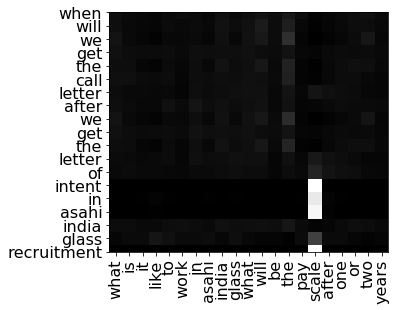

In [81]:
ex = 2

textA = train.iloc[ex].text1
textB = train.iloc[ex].text2
lab = train.iloc[ex].labels

print(f'Label = {lab}')
print(f'Text1 = {textA}')
print(f'Text2 = {textB}')

attn_scores = get_attention_scores(attention_model, textA, textB)

plot_attention(textB, textA, attn_scores, scale=False)

In [ ]:
# TODO: show that embeddings from the models are better than fasttext's

# How to improve?

* include triplet loss
* gain more data
* complex architecture

# Reference

* [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
* [Supervised Learning of Universal Sentence Representations from Natural Language Inference Data](https://arxiv.org/pdf/1705.02364.pdf)
* [Multiway Attention Networks for Modeling Sentence Pairs](https://www.ijcai.org/proceedings/2018/0613.pdf)
* [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
* [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/)